In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

In [9]:
df = pd.read_csv("diabetes_data_new_features.csv")

In [10]:
df

,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,visual blurring,Itching,Irritability,muscle stiffness,Obesity,class,Age >= 60
0,1,0,1,0,1,0,0,1,0,1,1,1,0
1,1,0,0,0,1,0,1,0,0,0,0,1,0
2,1,1,0,0,1,1,0,1,0,1,0,1,0
3,1,0,0,1,1,1,0,1,0,0,0,1,0
4,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,0,1,1,1,0,1,0,1,0,0,0,1,0
516,0,1,1,1,1,1,0,1,1,0,0,1,0
517,0,1,1,1,1,1,1,0,0,1,1,1,0
518,0,0,0,0,1,0,1,1,0,0,0,0,0


In [11]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [12]:
hc = HillClimbSearch(train_data)
bic_score = BicScore(train_data)

best_model_structure = hc.estimate(scoring_method=bic_score)

print("Adjusted Model Structure:")
for edge in best_model_structure.edges():
    print(edge)

  0%|          | 21/1000000 [00:00<4:18:38, 64.44it/s]


Adjusted Model Structure:
('Polyuria', 'class')
('Polyuria', 'Polydipsia')
('Polydipsia', 'weakness')
('sudden weight loss', 'Obesity')
('weakness', 'sudden weight loss')
('Polyphagia', 'Polyuria')
('Polyphagia', 'Age >= 60')
('visual blurring', 'Itching')
('visual blurring', 'Age >= 60')
('visual blurring', 'Polydipsia')
('Itching', 'weakness')
('Irritability', 'Obesity')
('muscle stiffness', 'visual blurring')
('muscle stiffness', 'Polyphagia')
('class', 'Polydipsia')
('class', 'sudden weight loss')
('class', 'Gender')
('class', 'visual blurring')
('class', 'Irritability')
('class', 'Itching')
('Age >= 60', 'Irritability')


In [13]:
model = BayesianNetwork(best_model_structure.edges())
model.fit(train_data, estimator=MaximumLikelihoodEstimator)
inference = VariableElimination(model)

In [14]:
predictions = []
for _, row in test_data.iterrows():
    try:
        evidence = row.to_dict()
        actual_outcome = evidence.pop('class', None)
        predicted_outcome = inference.map_query(variables=['class'], evidence=evidence)['class']
        predictions.append((predicted_outcome, actual_outcome))
    except Exception as e:
        print("Error processing row:", row)
        print("Exception:", e)
        break

if predictions:
    correct_predictions = sum(1 for pred, actual in predictions if pred == actual)
    accuracy = correct_predictions / len(predictions)
    print(f'Accuracy: {accuracy:.2f}')
else:
    print("No predictions made.")


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it

Accuracy: 0.94


In [15]:
print(classification_report([actual for pred, actual in predictions], [pred for pred, actual in predictions]))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91        33
           1       0.95      0.97      0.96        71

    accuracy                           0.94       104
   macro avg       0.94      0.93      0.93       104
weighted avg       0.94      0.94      0.94       104



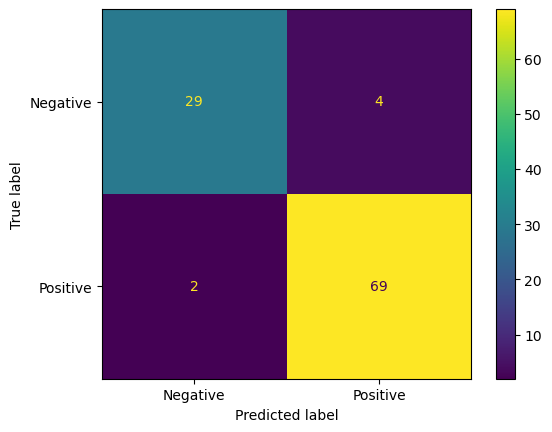

In [16]:
cm = confusion_matrix([actual for pred, actual in predictions], [pred for pred, actual in predictions])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot()
plt.show()